# Build a P-value Interpreter Function with ChatGPT

In [1]:
def interpret_p_value(p_value, threshold=0.05):
    """
    Interpret the p-value in a statistical context against a specific threshold.

    Parameters:
    p_value (float): The p-value to interpret, expected to be in the range 0 to 1.
    threshold (float): The significance level threshold, default is 0.05.

    Returns:
    None: Prints the interpretation of the p-value.

    Raises:
    ValueError: If the p_value or threshold is not within the range [0, 1].

    Description:
    This function assesses the provided p-value against a given threshold:
    - p < threshold: Evidence suggests rejecting the null hypothesis.
    - p >= threshold: Not enough evidence to reject the null hypothesis.

    It's important to note that the interpretation of p-values is context-dependent
    and should be considered along with other factors in statistical analysis.
    """
    if not (0 <= p_value <= 1):
        raise ValueError("p_value must be between 0 and 1.")
    if not (0 <= threshold <= 1):
        raise ValueError("threshold must be between 0 and 1.")

    if p_value < threshold:
        print(f"p-value ({p_value}) is less than the threshold ({threshold}).")
        print("Evidence suggests rejecting the null hypothesis.")
    else:
        print(f"p-value ({p_value}) is greater than or equal to the threshold ({threshold}).")
        print("Not enough evidence to reject the null hypothesis.")

# Example usage
interpret_p_value(0.03, threshold=0.05)

p-value (0.03) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


# Libraries and Data

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

In [3]:
# Load the data
df = pd.read_csv("Krushing Kingdoms.csv")
df.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention
0,250642234,level_5,21,True,False
1,330729049,level_5,1,False,False
2,955307973,level_7,76,True,True
3,908651903,level_7,76,True,False
4,983320188,level_5,1,False,False


In [4]:
# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 50000 non-null  int64 
 1   team_level_access  50000 non-null  object
 2   minutes_played     50000 non-null  int64 
 3   day1_retention     50000 non-null  bool  
 4   day7_retention     50000 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.2+ MB


# Define Hypothesis

**Null Hypothesis**: There is no difference in retention between two groups.

**Alternative Hypothesis**: There is a difference in the mean retention between the two groups.

## EDA

### Descriptive Statistics

In [5]:
df.describe()

,id,minutes_played
count,5.000000e+04,50000.000000
mean,5.000967e+08,25.884040
std,2.894632e+08,51.130086
min,7.746000e+03,0.000000
25%,2.502251e+08,3.000000
50%,5.008450e+08,8.000000
75%,7.500803e+08,26.000000
max,9.999952e+08,1481.000000


The data has outliers so will need cleaning.

### Group Comparisons

In [6]:
grouped = df.groupby('team_level_access').agg({'minutes_played': ['mean', 'median'],
                                               'day1_retention': 'mean',
                                               'day7_retention': 'mean'})
print(grouped)

                  minutes_played        day1_retention day7_retention
                            mean median           mean           mean
team_level_access                                                    
level_5                26.038934    9.0       0.448304       0.189176
level_7                25.732092    8.0       0.441561       0.181537


### Distribution of Team Level Access

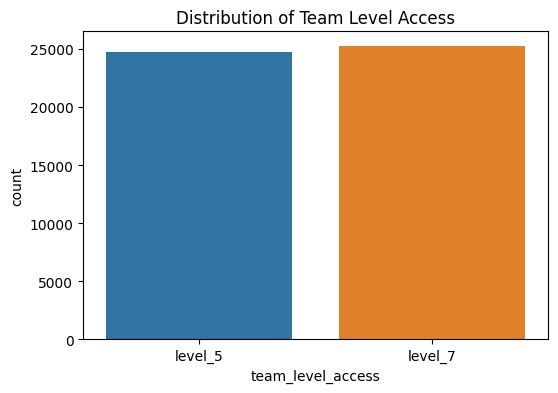

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='team_level_access', data=df)
plt.title('Distribution of Team Level Access')
plt.show();

### Boxplot of Minutes Played by Team Level

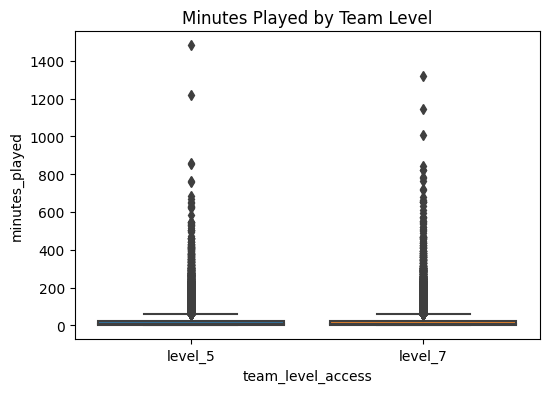

In [8]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='team_level_access', y='minutes_played', data=df)
plt.title('Minutes Played by Team Level')
plt.show();

### Binning the Minutes Played in to Categories

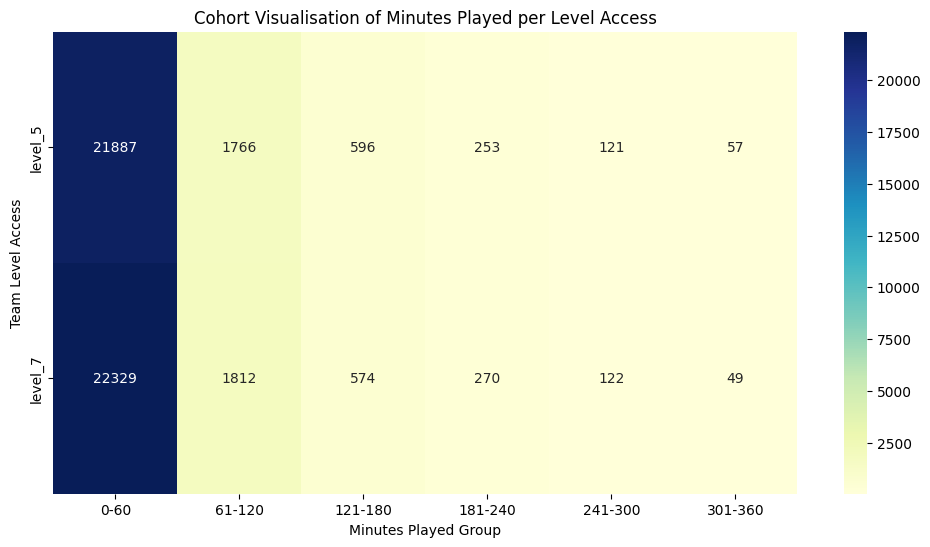

In [9]:
# This divides 'minutes_played' in to specified ranges to simplify analysis
bins = [0, 60, 120, 180, 240, 300, 360]
labels = ['0-60', '61-120', '121-180', '181-240', '241-300', '301-360']
df['minutes_played_group'] = pd.cut(df['minutes_played'],
                                    bins=bins,
                                    labels=labels,
                                    right=False)

# Creating a pivot table to summarise the count of 'minutes_pplayed_group' by 'team_level_access'
cohort_data = df.pivot_table(index='team_level_access',
                             columns='minutes_played_group',
                             aggfunc='size',
                             fill_value=0)

# Plotting the cohort data as a heatmap
# This visualises the distribution of 'minutes_played_group' across 'team_level_access'
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_data, annot=True, fmt='d', cmap='YlGnBu')

# Add title and label
plt.title('Cohort Visualisation of Minutes Played per Level Access')
plt.xlabel('Minutes Played Group')
plt.ylabel('Team Level Access')
plt.show();

## Outliers

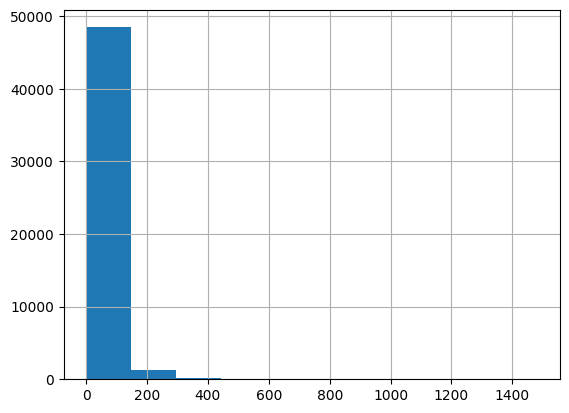

In [10]:
# Look at minutes_played
df['minutes_played'].hist();

In [11]:
# Calculating Interquartile Range (IQR) for 'minutes_played'
# This helps in identifying the range within which the central 50% of the data lies, useful for outlier detection
Q1 = df['minutes_played'].quantile(0.25) # First quartile (25th percentile)
Q3 = df['minutes_played'].quantile(0.75) # Third quartile (75th percentile)

IQR = Q3 - Q1 # Interquartile Range

In [12]:
# Defining outliers for 'minutes_played' based on the IQR method
# Outliers are data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR
outliers = ((df['minutes_played'] < (Q1 - 1.5 * IQR)) | (df['minutes_played'] > (Q3 + 1.5 * IQR)))

# Removing outliers from the dataset
df_cleaned = df[~outliers]

# Display summary statistics for the cleaned dataset
# This provides an overview of the data distribution after removing outliers
df_cleaned.describe()

,id,minutes_played
count,4.431900e+04,44319.000000
mean,4.993766e+08,12.208240
std,2.893929e+08,13.750095
min,7.746000e+03,0.000000
25%,2.491266e+08,2.000000
50%,5.000784e+08,7.000000
75%,7.496319e+08,17.000000
max,9.999952e+08,60.000000


## Randomisation

### Simple Randomisation

In [13]:
# Let's say '1' is for group A and '0' is for group B
number_of_users = 500
group_assignment = np.random.choice([0, 1],
                                    size=number_of_users,
                                    p=[0.5, 0.5])

# Count the number of elements per group
np.unique(group_assignment, return_counts=True)

(array([0, 1]), array([233, 267]))

### Block Randomisation

In [14]:
from sklearn.utils import shuffle

In [15]:
# Assuming that "block_size" is how many users we want in each group
block_size = 50
blocks =  [0] * block_size + [1] * block_size
group_assignment = shuffle(blocks * int(number_of_users / (2 * block_size)))

# Count the number of elements per group
np.unique(group_assignment, return_counts=True)

(array([0, 1]), array([250, 250]))

### Stratified Randomisation

In [16]:
# Build a copy of our DataFrame
df_stratified = df.copy()

In [17]:
# Create an age group variable
age_groups = ['18-25', '16-34', '36-45', '46-55']
df_stratified['age_group'] = np.random.choice(age_groups,
                                             size=len(df_stratified),
                                             replace=True)
df_stratified.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,age_group
0,250642234,level_5,21,True,False,0-60,16-34
1,330729049,level_5,1,False,False,0-60,18-25
2,955307973,level_7,76,True,True,61-120,16-34
3,908651903,level_7,76,True,False,61-120,16-34
4,983320188,level_5,1,False,False,0-60,46-55


In [18]:
# Build a function for stratified randomisation
def stratified_randomisation(group):
    # Assign 'A' or 'B' with equal probability
    group['group_assignment'] = np.random.choice(['A', 'B'],
                                                 size=len(group),
                                                 p=[0.5, 0.5])
    return group

In [19]:
# Apply the function
df_stratified = (df_stratified.groupby('age_group',
                                      group_keys=False)
                .apply(stratified_randomisation))
df_stratified.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,age_group,group_assignment
0,250642234,level_5,21,True,False,0-60,16-34,A
1,330729049,level_5,1,False,False,0-60,18-25,A
2,955307973,level_7,76,True,True,61-120,16-34,A
3,908651903,level_7,76,True,False,61-120,16-34,B
4,983320188,level_5,1,False,False,0-60,46-55,A


In [20]:
# Check the results
df_stratified.groupby(['age_group', 'group_assignment']).size()

age_group  group_assignment
16-34      A                   6258
           B                   6196
18-25      A                   6182
           B                   6233
36-45      A                   6228
           B                   6317
46-55      A                   6277
           B                   6309
dtype: int64

### Cluster Randomisation / Geotest

In [21]:
# Build a copy of our DataFrame
df_cluster = df.copy()

In [22]:
# Create a cities group variable
cities = ['New York', 'Los Angeles', 'Chicago', 'Houston']
df_cluster['city'] = np.random.choice(cities,
                                      size=len(df_cluster),
                                      replace=True)
df_cluster.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,city
0,250642234,level_5,21,True,False,0-60,Houston
1,330729049,level_5,1,False,False,0-60,Houston
2,955307973,level_7,76,True,True,61-120,Houston
3,908651903,level_7,76,True,False,61-120,Los Angeles
4,983320188,level_5,1,False,False,0-60,New York


In [23]:
# Create a list with two cities in each cluster
assigned_clusters = [0, 0, 1, 1]
np.random.shuffle(assigned_clusters)

In [24]:
# Create a dictionary to map out the city and the assigned cluster
city_to_group = dict(zip(cities, assigned_clusters))
city_to_group

{'New York': 1, 'Los Angeles': 0, 'Chicago': 0, 'Houston': 1}

In [25]:
# Create the cluster group variable
df_cluster['cluster_group'] = df_cluster['city'].map(city_to_group)
df_cluster.head()

,id,team_level_access,minutes_played,day1_retention,day7_retention,minutes_played_group,city,cluster_group
0,250642234,level_5,21,True,False,0-60,Houston,1
1,330729049,level_5,1,False,False,0-60,Houston,1
2,955307973,level_7,76,True,True,61-120,Houston,1
3,908651903,level_7,76,True,False,61-120,Los Angeles,0
4,983320188,level_5,1,False,False,0-60,New York,1


In [26]:
# Check the results
df_cluster.groupby(['city', 'cluster_group']).size()

city         cluster_group
Chicago      0                12217
Houston      1                12574
Los Angeles  0                12522
New York     1                12687
dtype: int64

# Sample Size Calculation

In [27]:
# Settings
alpha = 0.05
power = 0.8
# Minimum dedectable effect
mde = 0.05

## Sample Size Calculation for Proportions

In [28]:
# Computing the baseline percentage
baseline_retention = df_cleaned[df_cleaned['team_level_access'] == 'level_5']['day7_retention'].mean()
print(f'The Baseline Retention is {baseline_retention}')

The Baseline Retention is 0.11644772851669404


In [29]:
# Calculate the effect size
effect_size = sm.stats.proportion_effectsize(baseline_retention,
                                             baseline_retention + mde)

In [30]:
# Initiate the power analysis
power_analysis = sm.stats.NormalIndPower()
sample_size_discrete = power_analysis.solve_power(effect_size=effect_size,
                                                  power=power,
                                                  alpha=alpha,
                                                  ratio=1.0)
print(f"The Sample Size per group is {round(sample_size_discrete)}")

The Sample Size per group is 757


### Sample Size for Continuous Outcomes

In [31]:
# Computing the Baseline minutes
baseline_minutes = df_cleaned[df_cleaned['team_level_access'] == 'level_5']['minutes_played'].mean()
print(f"The Baseline Minutes is {baseline_minutes}")

# Baseline variablity
baseline_sigma = df_cleaned[df_cleaned['team_level_access'] == 'level_5']['minutes_played'].std()
print(f"The Baseline Variability is {baseline_sigma}")

The Baseline Minutes is 12.262953840540048
The Baseline Variability is 13.6339887214411


In [32]:
# Compute the effect size
effect_size = mde * baseline_minutes / baseline_sigma
print(f"The effect size is {effect_size}")

The effect size is 0.0449719964241098


In [33]:
# Alpha and beta
Zalpha = stats.norm.ppf(1 - alpha / 2)
Zbeta = stats.norm.ppf(power)

In [34]:
# Calculate the sample size
sample_size_continuous = ((Zalpha + Zbeta) ** 2 * (baseline_sigma ** 2)) / (effect_size ** 2)
print(f"The Sample Size per group is {sample_size_continuous:.0f}")

The Sample Size per group is 721388


### What if we don't clean the outliers?

In [35]:
 # Computing the Baseline minutes
baseline_minutes = df[df['team_level_access'] == 'level_5']['minutes_played'].mean()
print(f"The Baseline Minutes is {baseline_minutes}")

# Baseline variablity
baseline_sigma = df[df['team_level_access'] == 'level_5']['minutes_played'].std()
print(f"The Baseline Variability is {baseline_sigma}")

The Baseline Minutes is 26.038933764135702
The Baseline Variability is 50.95305446540207


In [36]:
# Compute the effect size
effect_size = mde * baseline_minutes / baseline_sigma
print(f"The effect size is {effect_size}")

The effect size is 0.025551886964712344


In [37]:
# Alpha and beta
Zalpha = stats.norm.ppf(1 - alpha / 2)
Zbeta = stats.norm.ppf(power)

In [38]:
# Calculate the sample size
sample_size_continuous = ((Zalpha + Zbeta) ** 2 * (baseline_sigma ** 2)) / (effect_size ** 2)
print(f"The Sample Size per group is {sample_size_continuous:.0f}")

The Sample Size per group is 31210604


#### Tips

* Always clean outliers for A/B Testing
* Choose the proportion as the main outcome KPI and the continuous as secondary

# Post Analysis

### Post Analysis for Retention with Calculated Sample Size

In [39]:
# Sampling
N = int(sample_size_discrete)
sample5 = df_cleaned[df_cleaned['team_level_access'] == 'level_5'].sample(n=N,
                                                                          random_state=1502)

sample7 = df_cleaned[df_cleaned['team_level_access'] == 'level_7'].sample(n=N,
                                                                          random_state=1502)

In [40]:
# Calculating the number of successes and trials
n_5 = sample5['day7_retention'].count()
n_7 = sample7['day7_retention'].count()
successes_5 = sample5['day7_retention'].sum()
successes_7 = sample7['day7_retention'].sum()

In [41]:
# Compute the level access retention rate
rr_5 = successes_5 / n_5
rr_7 = successes_7 / n_7
print(f"The retention rate for Level 5 is {rr_5}")
print(f"The retention rate for Level 7 is {rr_7}")

The retention rate for Level 5 is 0.11624834874504623
The retention rate for Level 7 is 0.10303830911492734


In [42]:
# Proportions Test
import statsmodels.stats.proportion as proportion
z_value, p_value = proportion.proportions_ztest([successes_5, successes_7],
                                                [n_5, n_7],
                                                alternative='two-sided')
interpret_p_value(p_value, threshold=0.05)

p-value (0.4107621742385773) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


### Post Analysis for Retention with the Complete Data

In [43]:
# Sampling
N = int(sample_size_discrete)
sample5 = df_cleaned[df_cleaned['team_level_access'] == 'level_5']

sample7 = df_cleaned[df_cleaned['team_level_access'] == 'level_7']

In [44]:
# Calculating the number of successes and trials
n_5 = sample5['day7_retention'].count()
n_7 = sample7['day7_retention'].count()
successes_5 = sample5['day7_retention'].sum()
successes_7 = sample7['day7_retention'].sum()

In [45]:
# Compute the level access retention rate
rr_5 = successes_5 / n_5
rr_7 = successes_7 / n_7
print(f"The retention rate for Level 5 is {rr_5}")
print(f"The retention rate for Level 7 is {rr_7}")

The retention rate for Level 5 is 0.11644772851669404
The retention rate for Level 7 is 0.10877427997320831


In [46]:
# Proportions Test
import statsmodels.stats.proportion as proportion
z_value, p_value = proportion.proportions_ztest([successes_5, successes_7],
                                                [n_5, n_7],
                                                alternative='two-sided')
interpret_p_value(p_value, threshold=0.05)

p-value (0.010607771169938515) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


### Post Analysis for Minutes Played

In [47]:
# Prepare the inputs
minutes5 = df_cleaned[df_cleaned['team_level_access'] == 'level_5']['minutes_played']
minutes7 = df_cleaned[df_cleaned['team_level_access'] == 'level_7']['minutes_played']

In [48]:
# 2 Sample T-Test
t_statistic, p_value = stats.ttest_ind(minutes5,
                                       minutes7,
                                       alternative='two-sided')
interpret_p_value(p_value, threshold=0.05)

p-value (0.40720311949312926) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.
